In [1]:
from astropy.io import fits
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

from scipy import cluster
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3
mpld3.disable_notebook()


/usr/local/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [399]:
goodstars = good_abundances(elements)

In [480]:
cluster_name = ['']*np.sum(goodstars)
for i, ID in enumerate(cat[1].data['APOGEE_ID'][goodstars]):
    whereid = np.where(ID == cluster_stars[0])[0]
    if len(whereid) > 0:
        cluster_name[i] = cluster_stars[1][whereid][0]
    else:
        cluster_name[i] = 'background'

In [517]:
header = 'GLON,GLAT,C/H,N/H,O/H,NA/H,MG/H,AL/H,SI/H,S/H,K/H,CA/H,TI/H,V/H,MN/H,FE/H,NI/H,Cluster'
dataset = np.vstack((cat[1].data['GLON'][goodstars],
                        cat[1].data['GLAT'][goodstars],
                        cat[1].data['C_H'][goodstars],
                        cat[1].data['N_H'][goodstars],
                        cat[1].data['O_H'][goodstars],
                        cat[1].data['NA_H'][goodstars],
                        cat[1].data['MG_H'][goodstars],
                        cat[1].data['AL_H'][goodstars],
                        cat[1].data['SI_H'][goodstars],
                        cat[1].data['S_H'][goodstars],
                        cat[1].data['K_H'][goodstars],
                        cat[1].data['CA_H'][goodstars],
                        cat[1].data['TI_H'][goodstars],
                        cat[1].data['V_H'][goodstars],
                        cat[1].data['MN_H'][goodstars],
                        cat[1].data['FE_H'][goodstars],
                        cat[1].data['NI_H'][goodstars],
                        np.array(cluster_name)))

frmt = ('%s, '*17)+'%s'
np.savetxt("APOGEE_chemicals.csv", dataset.T,
           delimiter=',',
           fmt=frmt, header=header)

In [10]:
cluster_stars = np.loadtxt('/Users/spardy/Research/data/APOGEE/table4.dat', usecols=(0, 1), dtype=('S', 'S'), unpack=True)

In [2]:
cat = fits.open('/Users/spardy/Research/data/APOGEE/allStar-v603.fits')
names = np.array([name[5:].rstrip() for name in cat[1].data['TARGET_ID']])

In [393]:
element_names = ['C_H', 'N_H', 'O_H', 'NA_H', 'MG_H', 'AL_H',
                 'SI_H', 'S_H', 'K_H', 'CA_H', 'TI_H', 'V_H',
                 'MN_H', 'FE_H', 'NI_H']
#element_scalings = [0.041, 0.044, 0.037, 0.111, 0.032, 0.055,
#                     0.041, 0.054, 0.069, 0.043, 0.072, 0.146,
#                     0.041, 0.019, 0.034]
element_scalings = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
elements = {}
for element, scale in zip(element_names, element_scalings):
    elements[element] = cat[1].data[element]/scale


In [235]:
cluster_name = 'M13'
cluststars = [name for name in cluster_stars[0][cluster_stars[1] == cluster_name]]

In [397]:
def good_abundances(data, index=None):
    if index is not None:
        good = np.ones_like(index, dtype=bool)
        for element in element_names:
            good *= data[element][index] > -9999
    else:
        good = np.ones(len(data[element_names[0]]), dtype=bool)
        for element in element_names:
            good *= data[element] > -9999

    return good

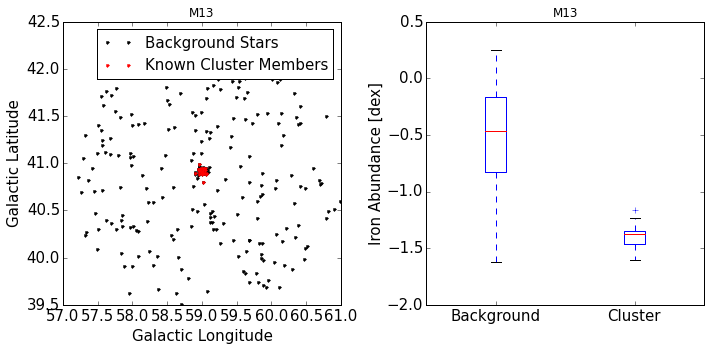

In [329]:
fig, axes = plt.subplots(1,2, figsize=(10, 5))
ind = []

for i, cluststar in enumerate(cluststars): 
    _ind = np.where(names == cluststar)[0][0]
    if good_abundances(elements, _ind):
        ind.append(_ind)


avg_glon = np.mean(cat[1].data['GLON'][ind])
avg_glat = np.mean(cat[1].data['GLAT'][ind])

within_box = np.where((np.abs(cat[1].data['GLON'] - avg_glon) < 2)*
                      (np.abs(cat[1].data['GLAT'] - avg_glat) < 2)*
                      good_abundances(elements, range(len(cat[1].data['GLON']))))


labels_true = np.zeros(len(within_box[0]))-1

for i, cluststar in enumerate(cluststars): 
    _ind = np.where(names == cluststar)[0][0]
    if good_abundances(elements, _ind):
        _ = np.where(names[within_box] == cluststar)[0]
        labels_true[_] = 0

axis = axes[0]
axis.plot(cat[1].data['GLON'][within_box],
         cat[1].data['GLAT'][within_box], 'k.', zorder=-1, label='Background Stars')

  
axis.plot(cat[1].data['GLON'][ind], cat[1].data['GLAT'][ind], 'r.', label='Known Cluster Members')#, markerfacecolor='none', markeredgecolor='r')
axis.set_xlabel('Galactic Longitude', fontsize=15)
axis.set_ylabel('Galactic Latitude', fontsize=15)
axis.set_title(cluster_name)
axis.legend(loc='upper right', fontsize=15)
axis.tick_params(axis='both', which='major', labelsize=15)

axis = axes[1]
axis.boxplot((cat[1].data['FE_H'][within_box], cat[1].data['FE_H'][ind]),
             labels=['Background', 'Cluster'])
axis.set_ylabel('Iron Abundance [dex]', fontsize=15)
axis.tick_params(axis='both', which='major', labelsize=15)
#tot = np.sum(cat[1].data['FE_H'][within_box])
#axis.plot(np.linspace(0, 1, len(within_box[0])), np.cumsum(sorted(cat[1].data['FE_H'][within_box]))/tot)
#tot = np.sum(cat[1].data['FE_H'][ind])
#axis.plot(np.linspace(0, 1, len(ind)), np.cumsum(sorted(cat[1].data['FE_H'][ind]))/tot)
  
#axis.plot(cat[1].data['GLON'][ind], cat[1].data['GLAT'][ind], 'r.', label='Known Cluster Members')#, markerfacecolor='none', markeredgecolor='r')
plt.tight_layout()

axis.set_title(cluster_name)
plt.savefig('/Users/spardy/Desktop/M13_metal_spread.png', dpi=600, bbox_inches='tight')

In [369]:
header = "FE/H,C/H,MG/H,NA/H,AL/H,cluster"
frmt = ('%5.5f,'*5)+'%d'
field_stars = np.setdiff1d(within_box, ind)

dataset = np.vstack((np.concatenate((cat[1].data['FE_H'][ind], cat[1].data['FE_H'][field_stars])),
                     np.concatenate((cat[1].data['C_H'][ind], cat[1].data['C_H'][field_stars])),
                     np.concatenate((cat[1].data['MG_H'][ind], cat[1].data['MG_H'][field_stars])),
                     np.concatenate((cat[1].data['NA_H'][ind], cat[1].data['NA_H'][field_stars])),
                     np.concatenate((cat[1].data['AL_H'][ind], cat[1].data['AL_H'][field_stars])),
                     np.concatenate((np.zeros(len(ind)), np.ones(len(field_stars))) )))
np.savetxt("M13_chemicals.csv", dataset.T, fmt=frmt, header=header)

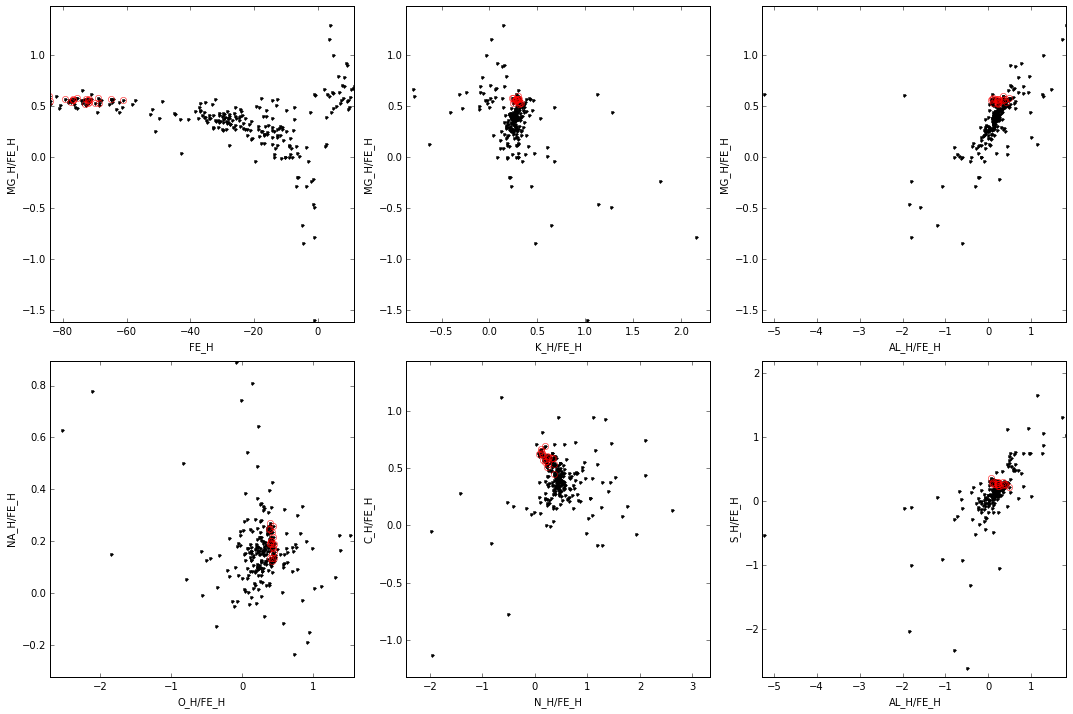

In [237]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

xlabels = ['FE_H', 'K_H', 'AL_H', 'O_H', 'N_H', 'AL_H']
ylabels = ['MG_H', 'MG_H', 'MG_H', 'NA_H', 'C_H', 'S_H']

for axis, xlabel, ylabel in zip(axes, xlabels, ylabels):
    if (xlabel != 'FE_H'):
        xscale = elements['FE_H']
        xscalename = '/FE_H'
    else:
        xscale = np.ones_like(elements['FE_H'])
        xscalename = ''
    if (ylabel != 'FE_H'):
        yscale = elements['FE_H']
        yscalename = '/FE_H'
    else:
        yscale = np.ones_like(elements['FE_H'])
        yscalename = ''
        
    axis.plot(elements[xlabel][within_box]/xscale[within_box],
              elements[ylabel][within_box]/yscale[within_box],
              'k.', zorder=-1)

    axis.plot(elements[xlabel][ind]/xscale[ind],
              elements[ylabel][ind]/yscale[ind],
              'o', markerfacecolor='none', markeredgecolor='r')
    
    xhigh = np.percentile(elements[xlabel][within_box]/xscale[within_box], 99)
    xlow = np.percentile(elements[xlabel][within_box]/xscale[within_box], 1)
    yhigh = np.percentile(elements[ylabel][within_box]/yscale[within_box], 99)
    ylow = np.percentile(elements[ylabel][within_box]/yscale[within_box], 1)    

    axis.set_xlim([xlow, xhigh])
    axis.set_ylim([ylow, yhigh])

    axis.set_ylabel(ylabel+yscalename)
    axis.set_xlabel(xlabel+xscalename)

plt.tight_layout()

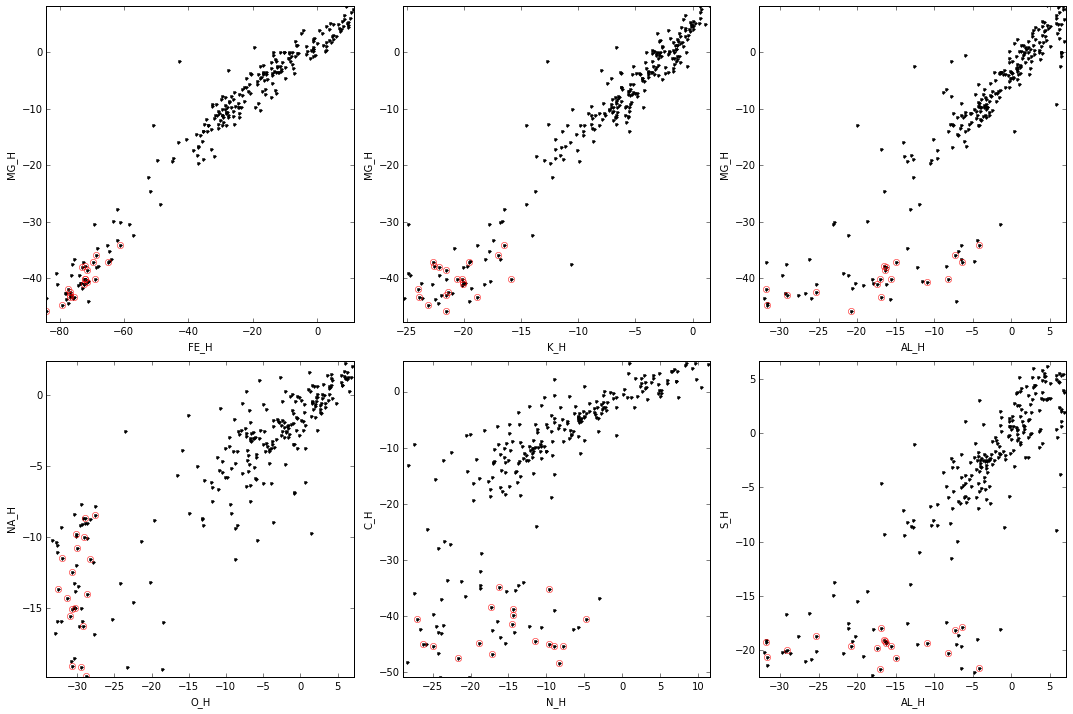

In [238]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

xlabels = ['FE_H', 'K_H', 'AL_H', 'O_H', 'N_H', 'AL_H']
ylabels = ['MG_H', 'MG_H', 'MG_H', 'NA_H', 'C_H', 'S_H']

for axis, xlabel, ylabel in zip(axes, xlabels, ylabels):
    axis.plot(elements[xlabel][within_box],
              elements[ylabel][within_box],
              'k.', zorder=-1)

    axis.plot(elements[xlabel][ind],
              elements[ylabel][ind],
              'o', markerfacecolor='none', markeredgecolor='r')
    
    xhigh = np.percentile(elements[xlabel][within_box], 99)
    xlow = np.percentile(elements[xlabel][within_box], 1)
    yhigh = np.percentile(elements[ylabel][within_box], 99)
    ylow = np.percentile(elements[ylabel][within_box], 1)    

    axis.set_xlim([xlow, xhigh])
    axis.set_ylim([ylow, yhigh])

    axis.set_ylabel(ylabel)
    axis.set_xlabel(xlabel)

plt.tight_layout()

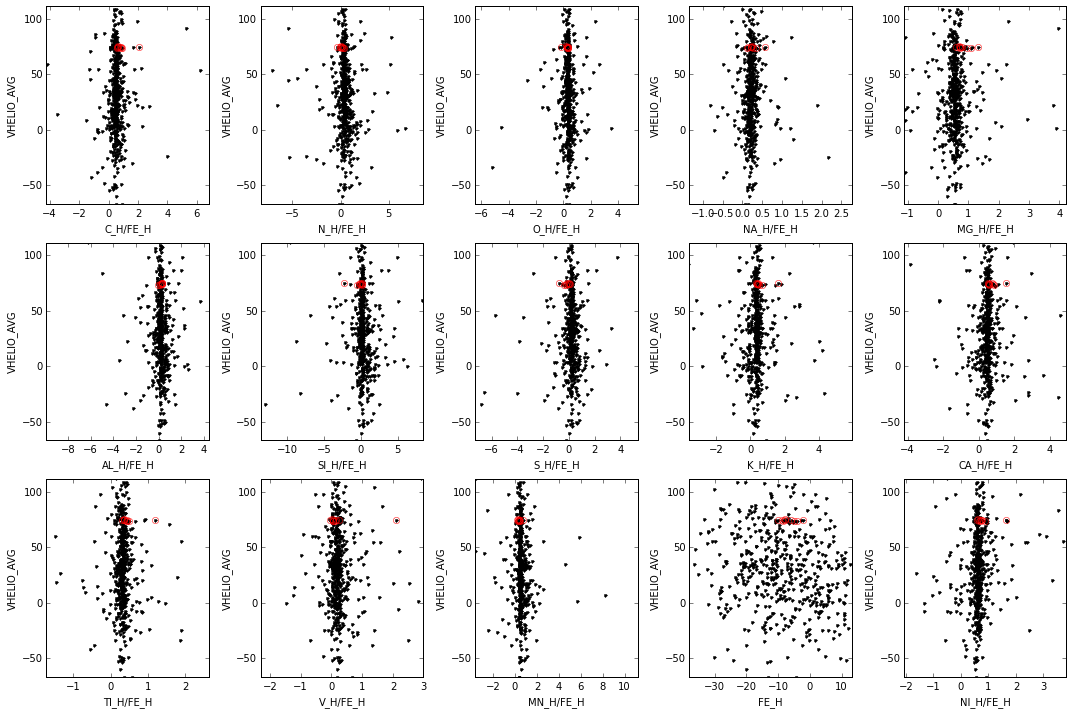

In [201]:
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.flatten()

ylabel = 'VHELIO_AVG'

for axis, xlabel in zip(axes, element_names):
    if (xlabel != 'FE_H'):
        xscale = elements['FE_H']
        xscalename = '/FE_H'
    else:
        xscale = np.ones_like(elements['FE_H'])
        xscalename = ''
        
    axis.plot(elements[xlabel][within_box]/xscale[within_box],
              cat[1].data[ylabel][within_box],
              'k.', zorder=-1)

    axis.plot(elements[xlabel][ind]/xscale[ind],
              cat[1].data[ylabel][ind],
              'o', markerfacecolor='none', markeredgecolor='r')

    xhigh = np.percentile(elements[xlabel][within_box]/xscale[within_box], 99)
    xlow = np.percentile(elements[xlabel][within_box]/xscale[within_box], 1)
    yhigh = np.percentile(cat[1].data[ylabel][within_box], 99)
    ylow = np.percentile(cat[1].data[ylabel][within_box], 1)  

    axis.set_xlim([xlow, xhigh])
    axis.set_ylim([ylow, yhigh])

    axis.set_ylabel(ylabel)
    axis.set_xlabel(xlabel+xscalename)

plt.tight_layout()

In [239]:
X = np.vstack((elements[name][within_box] for name in element_names)).T
#X = np.vstack((X, cat[1].data['VHELIO_AVG'][within_box])).T

In [251]:
eps = 10
min_samples = 20
db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
##############################################################################
# Plot result

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
  % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
  % metrics.adjusted_mutual_info_score(labels_true, labels))
if n_clusters_ > 0:
    print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

Estimated number of clusters: 1
Homogeneity: 0.293
Completeness: 0.119
V-measure: 0.169
Adjusted Rand Index: 0.117
Adjusted Mutual Information: 0.116
Silhouette Coefficient: 0.466


In [212]:
Homogeneity = np.empty((10, 10))
Completeness = np.empty((10, 10))
V_measure = np.empty((10, 10))
Adjusted_Rand_Index = np.empty((10, 10))
Adjusted_Mutual_Information = np.empty((10, 10))
Silhouette_Coefficient = np.empty((10, 10))

for i, eps in enumerate(np.linspace(1, 10, 10)):
    for j, min_sample in enumerate(np.linspace(11, 20, 10)):
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

        Homogeneity[i, j] = metrics.homogeneity_score(labels_true, labels)
        Completeness[i, j] = metrics.completeness_score(labels_true, labels)
        V_measure[i, j] = metrics.v_measure_score(labels_true, labels)
        Adjusted_Rand_Index[i, j] = metrics.adjusted_rand_score(labels_true, labels)
        Adjusted_Mutual_Information[i, j] = metrics.adjusted_mutual_info_score(labels_true, labels)
        if n_clusters_ > 0:
            Silhouette_Coefficient[i, j] = metrics.silhouette_score(X, labels)
        else:
            Silhouette_Coefficient[i, j] = np.nan

In [214]:
V_measure.argmax()

50

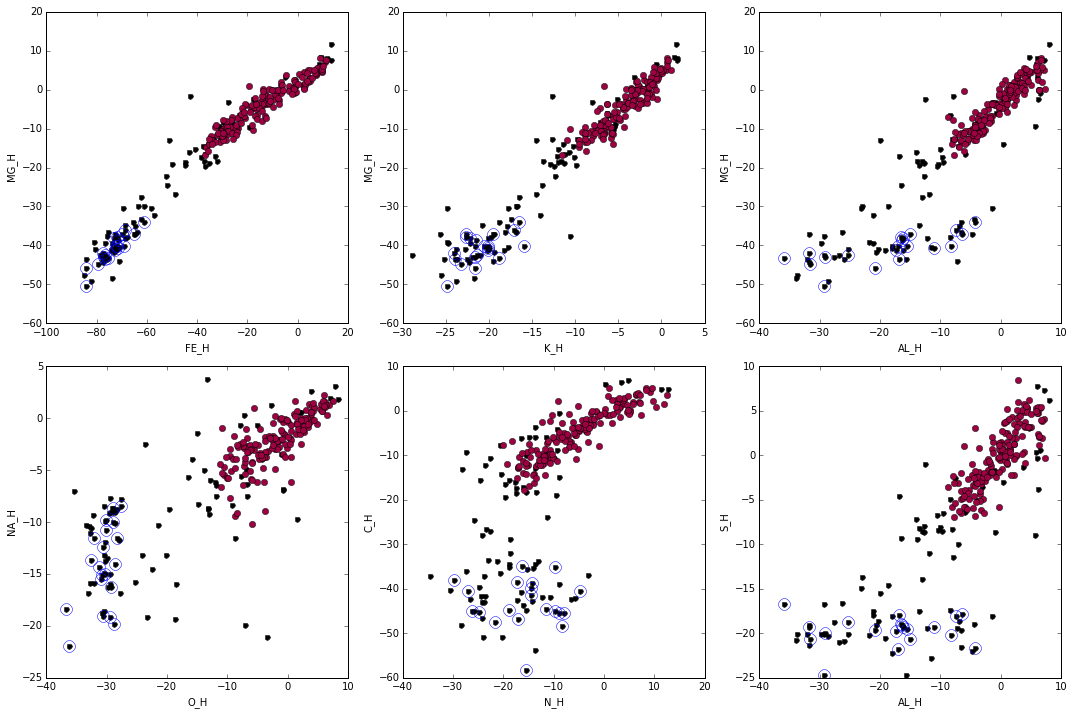

In [252]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

xlabels = ['FE_H', 'K_H', 'AL_H', 'O_H', 'N_H', 'AL_H']
ylabels = ['MG_H', 'MG_H', 'MG_H', 'NA_H', 'C_H', 'S_H']

for axis, xlabel, ylabel in zip(axes, xlabels, ylabels):
    for k, col in zip(unique_labels, colors):
        class_member_mask = (labels == k)
        if k == -1:
            # Black used for noise.
            col = 'k'
            x = elements[xlabel][within_box][class_member_mask]
            y = elements[ylabel][within_box][class_member_mask]
            #print np.std(xy, axis=1)
            axis.plot(x, y, '.', markerfacecolor=col,
                     markeredgecolor='k', markersize=10, zorder=-1)
        else:
            x = elements[xlabel][within_box][class_member_mask & core_samples_mask]
            y = elements[ylabel][within_box][class_member_mask & core_samples_mask]
            axis.plot(x, y, '.', markerfacecolor=col,
                     markeredgecolor='k', markersize=12)

            x = elements[xlabel][within_box][class_member_mask & ~core_samples_mask]
            y = elements[ylabel][within_box][class_member_mask & ~core_samples_mask]
            axis.plot(x, y, '.', markerfacecolor=col,
                     markeredgecolor='k', markersize=12)


    xhigh = np.percentile(elements[xlabel][ind], 99)
    xlow = np.percentile(elements[xlabel][ind], 1)
    yhigh = np.percentile(elements[ylabel][ind], 99)
    ylow = np.percentile(elements[ylabel][ind], 1) 

    x = elements[xlabel][ind]
    y = elements[ylabel][ind]
    axis.plot(x, y, 'o', markerfacecolor='none', markeredgecolor='blue', markersize=12)

    #axis.set_xlim([xlow, xhigh])
    #axis.set_ylim([ylow, yhigh])

    axis.set_ylabel(ylabel)
    axis.set_xlabel(xlabel)



plt.tight_layout()

    #axis.set_title('eps=%3.2f\nEstimated number of clusters: %d' % (eps, n_clusters_))

[ 0.04365602  0.05007645]
Estimated number of clusters: 1
Homogeneity: 0.233
Completeness: 0.152
V-measure: 0.184
Adjusted Rand Index: 0.285
Adjusted Mutual Information: 0.148
Silhouette Coefficient: 0.090


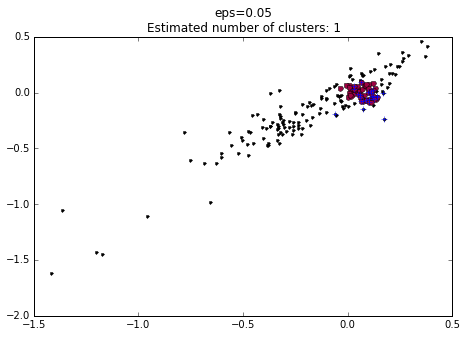

In [276]:
fig, axis = plt.subplots(figsize=(7.5, 5))
#axes = axes.flatten()
#for axis, eps in zip(axes, [0.01, 0.02, 0.03, 0.04]):
DBSCAN_plot(axis, X, 0.05, 15, labels_true)

## Hierarchical CLustering

11 0
1.56513
12 0
1.86217
11 0
2.31535
15 0
1.72502
27 0
3.08703
14 0
1.74945
12 0
1.67053
12 0
1.48741
Estimated number of clusters: 9
Homogeneity: 0.048
Completeness: 0.004
V-measure: 0.008
Adjusted Rand Index: -0.027
Adjusted Mutual Information: -0.002
Silhouette Coefficient: -0.383


/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:32: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 533 but corresponding boolean dimension is 173
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:33: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 533 but corresponding boolean dimension is 173


(-6.3720301055908202, -3.1259348869323733)

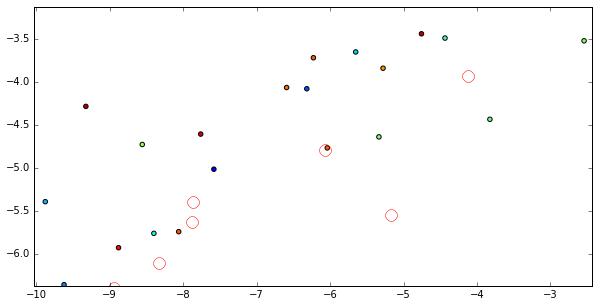

In [217]:
Z = cluster.hierarchy.complete(X)
max_d = 1.1
min_samples = 10
labels = cluster.hierarchy.fcluster(Z, max_d)
unq_clusters = np.unique(labels)
for ucluster in unq_clusters:
    match = labels == ucluster
    if np.sum(match) > min_samples:
        print np.sum(match), np.sum(labels_true[match] == 0)
        print np.std(X[match, :], axis=0).mean()
    else:
        labels[match] = -1
    
unq_clusters = np.unique(labels)
n_clusters_ = len(unq_clusters)
print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
  % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
  % metrics.adjusted_mutual_info_score(labels_true, labels))
if n_clusters_ > 0:
    print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

fig, axis = plt.subplots(1, figsize=(10, 5))

xlabel = 'FE_H'
ylabel = 'MG_H'
axis.scatter(elements[xlabel][within_box][clusters > -1],
                elements[ylabel][within_box][clusters > -1],
                c=clusters)  # plot points with cluster dependent colors

axis.plot(elements[xlabel][ind],
                elements[ylabel][ind], 'o',
         markerfacecolor='none', markeredgecolor='red', markersize=12)
xhigh = np.percentile(elements[xlabel][ind], 99)
xlow = np.percentile(elements[xlabel][ind], 1)
yhigh = np.percentile(elements[ylabel][ind], 99)
ylow = np.percentile(elements[ylabel][ind], 1) 

axis.set_xlim([xlow, xhigh])
axis.set_ylim([ylow, yhigh])

## Ward

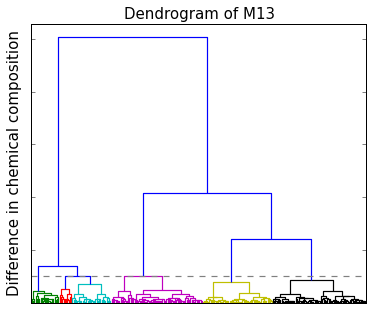

In [340]:
default_linewidth = matplotlib.rcParams['lines.linewidth']

def color_func(k):
    print k
    return 'black'

Z = cluster.hierarchy.ward(X)
max_d = 100
clusters = cluster.hierarchy.fcluster(Z, max_d, criterion='distance')
fig, axis = plt.subplots(1, figsize=(6, 5))

matplotlib.rcParams['lines.linewidth'] = 1.2

dendro = cluster.hierarchy.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    #no_plot=True,
    ax=axis,
    color_threshold = max_d
)

axis.set_xticklabels([])
axis.set_yticklabels([])
axis.axhline(y=max_d, linestyle='--', color='gray')
axis.set_ylabel('Difference in chemical composition', fontsize=15)
axis.set_title('Dendrogram of M13', fontsize=15)
plt.savefig('/Users/spardy/Desktop/M13_dendrogram.png', dpi=600)
matplotlib.rcParams['lines.linewidth'] = default_linewidth


(-49.516165504455572, -34.412100639343265)

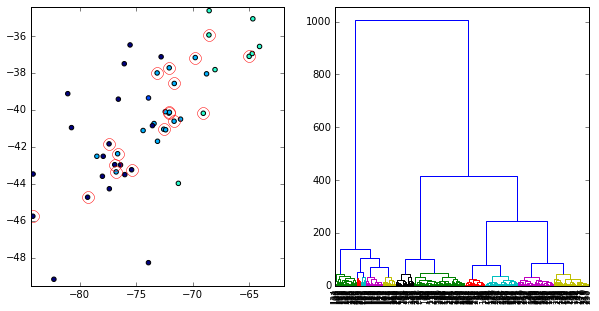

In [256]:
Z = cluster.hierarchy.ward(X)
max_d = 50
clusters = cluster.hierarchy.fcluster(Z, max_d, criterion='distance')
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
dendro = cluster.hierarchy.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    #no_plot=True,
    ax=axes[1],
    color_threshold = max_d
)
xlabel = 'FE_H'
ylabel = 'MG_H'
axes[0].scatter(elements[xlabel][within_box],
                elements[ylabel][within_box],
                c=clusters)  # plot points with cluster dependent colors

axes[0].plot(elements[xlabel][ind],
                elements[ylabel][ind], 'o',
         markerfacecolor='none', markeredgecolor='red', markersize=12)
xhigh = np.percentile(elements[xlabel][ind], 99)
xlow = np.percentile(elements[xlabel][ind], 1)
yhigh = np.percentile(elements[ylabel][ind], 99)
ylow = np.percentile(elements[ylabel][ind], 1) 

axes[0].set_xlim([xlow, xhigh])
axes[0].set_ylim([ylow, yhigh])

## Median

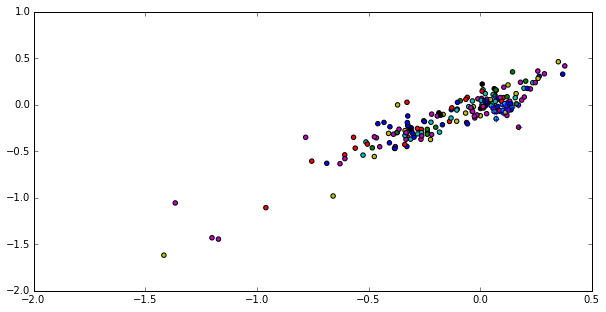

In [232]:
Z = cluster.hierarchy.median(X)
max_d = 0.1
clusters = cluster.hierarchy.fcluster(Z, max_d, criterion='distance')
fig, axis = plt.subplots(figsize=(10, 5))
dendro = cluster.hierarchy.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    color_threshold = max_d,
    no_plot=True
)
axis.scatter(X[:,0], X[:,1], c=dendro['color_list'])  # plot points with cluster dependent colors
axis.plot(cat[1].data['FE_H'][ind],
         cat[1].data['C_H'][ind], '+',
         markerfacecolor='blue', markeredgecolor='blue')


## Complete 

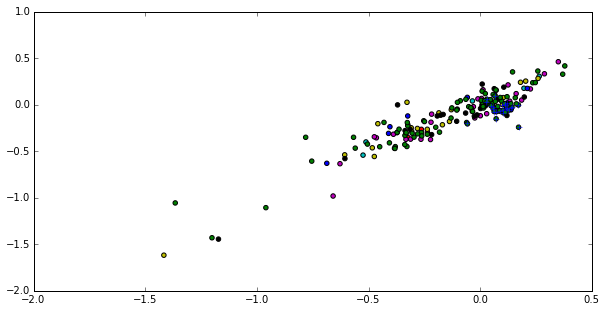

In [233]:
Z = cluster.hierarchy.complete(X)
max_d = 0.5
clusters = cluster.hierarchy.fcluster(Z, max_d, criterion='distance')
fig, axis = plt.subplots(figsize=(10, 5))
dendro = cluster.hierarchy.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    no_plot=True,
    color_threshold = max_d
)
axis.scatter(X[:,0], X[:,1], c=dendro['color_list'])  # plot points with cluster dependent colors
axis.plot(cat[1].data['FE_H'][ind],
         cat[1].data['C_H'][ind], '+',
         markerfacecolor='blue', markeredgecolor='blue')


417